<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Feature Engineering
</font>
</h1>


<p dir="ltr" style="direction: ltr; text-align: justify; line-height: 200%; font-family: Arial; font-size: medium">
<font face="Arial" size="3">
High-quality models require high-quality data. Without excellent data, excellent models cannot exist. Here, we will be practising some feature engineering and data preprocessing with ashrae-energy data.
<p dir="ltr" style="direction: ltr; text-align: justify; line-height: 200%; font-family: Arial; font-size: medium">
We will address the following:
<ul dir="ltr">
  <li dir="ltr" style="direction: ltr; text-align: justify; line-height: 200%; font-family: Arial; font-size: medium">
    Filling missing values
  <li dir="ltr" style="direction: ltr; text-align: justify; line-height: 200%; font-family: Arial; font-size: medium">
    Encoding categorical variables
  <li dir="ltr" style="direction: ltr; text-align: justify; line-height: 200%; font-family: Arial; font-size: medium">
    Transforming numerical variables and changing their distribution
</ul>
</font>


<h2 align="left" style="line-height: 200%; font-family: Arial; color: #0099cc">
<font face="Arial" color="#0099cc">
Dataset
</font>
</h2>

<p dir="ltr" style="direction: ltr; text-align: justify; line-height: 200%; font-family: Arial; font-size: medium">
<font face="Arial" size="3">
The dataset we will be working with is derived from <a href="https://www.kaggle.com/competitions/ashrae-energy-prediction/data">this competition</a>.This dataset contains hourly energy consumption recordings for over a thousand buildings over three years in various locations worldwide.
</font>
</p>


In [1]:
# Download dataset zip file
!gdown 1-EUuljtwZ2aO2lPj5oqWSiAp-1WGdrKY

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-EUuljtwZ2aO2lPj5oqWSiAp-1WGdrKY
From (redirected): https://drive.google.com/uc?id=1-EUuljtwZ2aO2lPj5oqWSiAp-1WGdrKY&confirm=t&uuid=ac2d6187-9243-4faf-9984-5bac8d0e3d0b
To: /home/hossein/my-projects/data-science-quera/Ex_6/1_feature_engineering/ashrae-energy-prediction.zip
100%|████████████████████████████████████████| 397M/397M [04:12<00:00, 1.57MB/s]


In [2]:
# Unzip the zip file
!unzip ashrae-energy-prediction.zip

Archive:  ashrae-energy-prediction.zip
  inflating: building_metadata.csv   
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
  inflating: weather_test.csv        
  inflating: weather_train.csv       


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
# Load data
train_df = pd.read_csv('train.csv')
building_metadata_df = pd.read_csv('building_metadata.csv')
weather_df = pd.read_csv('weather_train.csv')

In [3]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
building_metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [6]:
# Merge the dataframes
train_building = pd.merge(train_df, building_metadata_df, on='building_id')
merged_data = pd.merge(train_building, weather_df, on=['timestamp', 'site_id'])

In [7]:
merged_data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [8]:
# Delete the dataframes after merging to free up memory
del train_df
del building_metadata_df
del weather_df
del train_building

In [9]:
# Filtering meter 0 data because we want to use only electricity data
filtered_data = merged_data.loc[merged_data.meter == 0].drop('meter', axis=1)

In [10]:
filtered_data.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [11]:
# Delete the merged_data dataframe to free up memory
del merged_data
data = filtered_data.copy()
del filtered_data

In [12]:
# Convert meter_reading from kBTU to kWh for site_id = 0
KWH_PER_KBTU = 0.293071
data.loc[data.site_id == 0, 'meter_reading'] *= KWH_PER_KBTU

In [13]:
# Describe data
data.describe()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,1.201741e+07,1.201741e+07,1.201741e+07,1.201741e+07,5.554673e+06,2.958739e+06,1.201358e+07,6.731258e+06,1.201182e+07,9.547231e+06,1.104253e+07,1.138220e+07,1.199412e+07
mean,7.047326e+02,1.585251e+02,6.727073e+00,9.270128e+04,1.968372e+03,3.794100e+00,1.600965e+01,2.284164e+00,8.334990e+00,8.015276e-01,1.016408e+03,1.763599e+02,3.559324e+00
std,4.143301e+02,3.669913e+02,4.935491e+00,1.121460e+05,3.102379e+01,3.359483e+00,1.039774e+01,2.553476e+00,9.836796e+00,7.718845e+00,7.035792e+00,1.128772e+02,2.317835e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.440000e+02,1.895000e+01,3.000000e+00,2.301200e+04,1.950000e+03,1.000000e+00,8.900000e+00,0.000000e+00,1.100000e+00,0.000000e+00,1.012100e+03,8.000000e+01,2.100000e+00
50%,6.960000e+02,5.930800e+01,5.000000e+00,5.781100e+04,1.970000e+03,3.000000e+00,1.670000e+01,2.000000e+00,9.400000e+00,0.000000e+00,1.016500e+03,1.800000e+02,3.100000e+00
75%,1.061000e+03,1.561440e+02,1.200000e+01,1.161210e+05,1.996000e+03,5.000000e+00,2.390000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020700e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,7.976900e+04,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


In [14]:
# Run df.info() function on data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017408 entries, 0 to 20115157
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   timestamp           object 
 2   meter_reading       float64
 3   site_id             int64  
 4   primary_use         object 
 5   square_feet         int64  
 6   year_built          float64
 7   floor_count         float64
 8   air_temperature     float64
 9   cloud_coverage      float64
 10  dew_temperature     float64
 11  precip_depth_1_hr   float64
 12  sea_level_pressure  float64
 13  wind_direction      float64
 14  wind_speed          float64
dtypes: float64(10), int64(3), object(2)
memory usage: 1.4+ GB


In [15]:
#‌ ‌Reduce‌ ‌memory‌ ‌usage‌ ‌by‌ ‌converting‌ ‌column‌ ‌data‌ ‌types‌ ‌
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Compute memory usage
    start_mem = df.memory_usage().sum() / 1024**2
    # Iterate through each column
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    # Compute memory usage after reduction
    end_mem = df.memory_usage().sum() / 1024**2
    # Print out the difference between memory usage before and after
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
# Apply reduce_memory_usage function to data
data = reduce_memory_usage(data)

Mem. usage decreased to 607.42 Mb (58.6% reduction)


In [17]:
# Run df.info() function on data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017408 entries, 0 to 20115157
Data columns (total 15 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int16  
 1   timestamp           object 
 2   meter_reading       float32
 3   site_id             int8   
 4   primary_use         object 
 5   square_feet         int32  
 6   year_built          float16
 7   floor_count         float16
 8   air_temperature     float16
 9   cloud_coverage      float16
 10  dew_temperature     float16
 11  precip_depth_1_hr   float16
 12  sea_level_pressure  float16
 13  wind_direction      float16
 14  wind_speed          float16
dtypes: float16(9), float32(1), int16(1), int32(1), int8(1), object(2)
memory usage: 607.4+ MB


In [18]:
# Remove the rows where meter_reading is 0
data = data.loc[data['meter_reading'] != 0]

In [19]:
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Add month column
data['month'] = data['timestamp'].dt.month.astype(np.int8)

In [20]:
# Run df.info() function on data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11488187 entries, 45 to 20115157
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   timestamp           datetime64[ns]
 2   meter_reading       float32       
 3   site_id             int8          
 4   primary_use         object        
 5   square_feet         int32         
 6   year_built          float16       
 7   floor_count         float16       
 8   air_temperature     float16       
 9   cloud_coverage      float16       
 10  dew_temperature     float16       
 11  precip_depth_1_hr   float16       
 12  sea_level_pressure  float16       
 13  wind_direction      float16       
 14  wind_speed          float16       
 15  month               int8          
dtypes: datetime64[ns](1), float16(9), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 591.6+ MB


In [22]:
# Exploratory data analysis
import missingno as msno

In [23]:
# Check for missing values
data.isnull().sum(axis=0) / data.shape[0] * 100

building_id            0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            55.031529
floor_count           74.691777
air_temperature        0.029317
cloud_coverage        43.884444
dew_temperature        0.044228
precip_depth_1_hr     21.222592
sea_level_pressure     8.340724
wind_direction         5.305598
wind_speed             0.196036
month                  0.000000
dtype: float64

<Axes: >

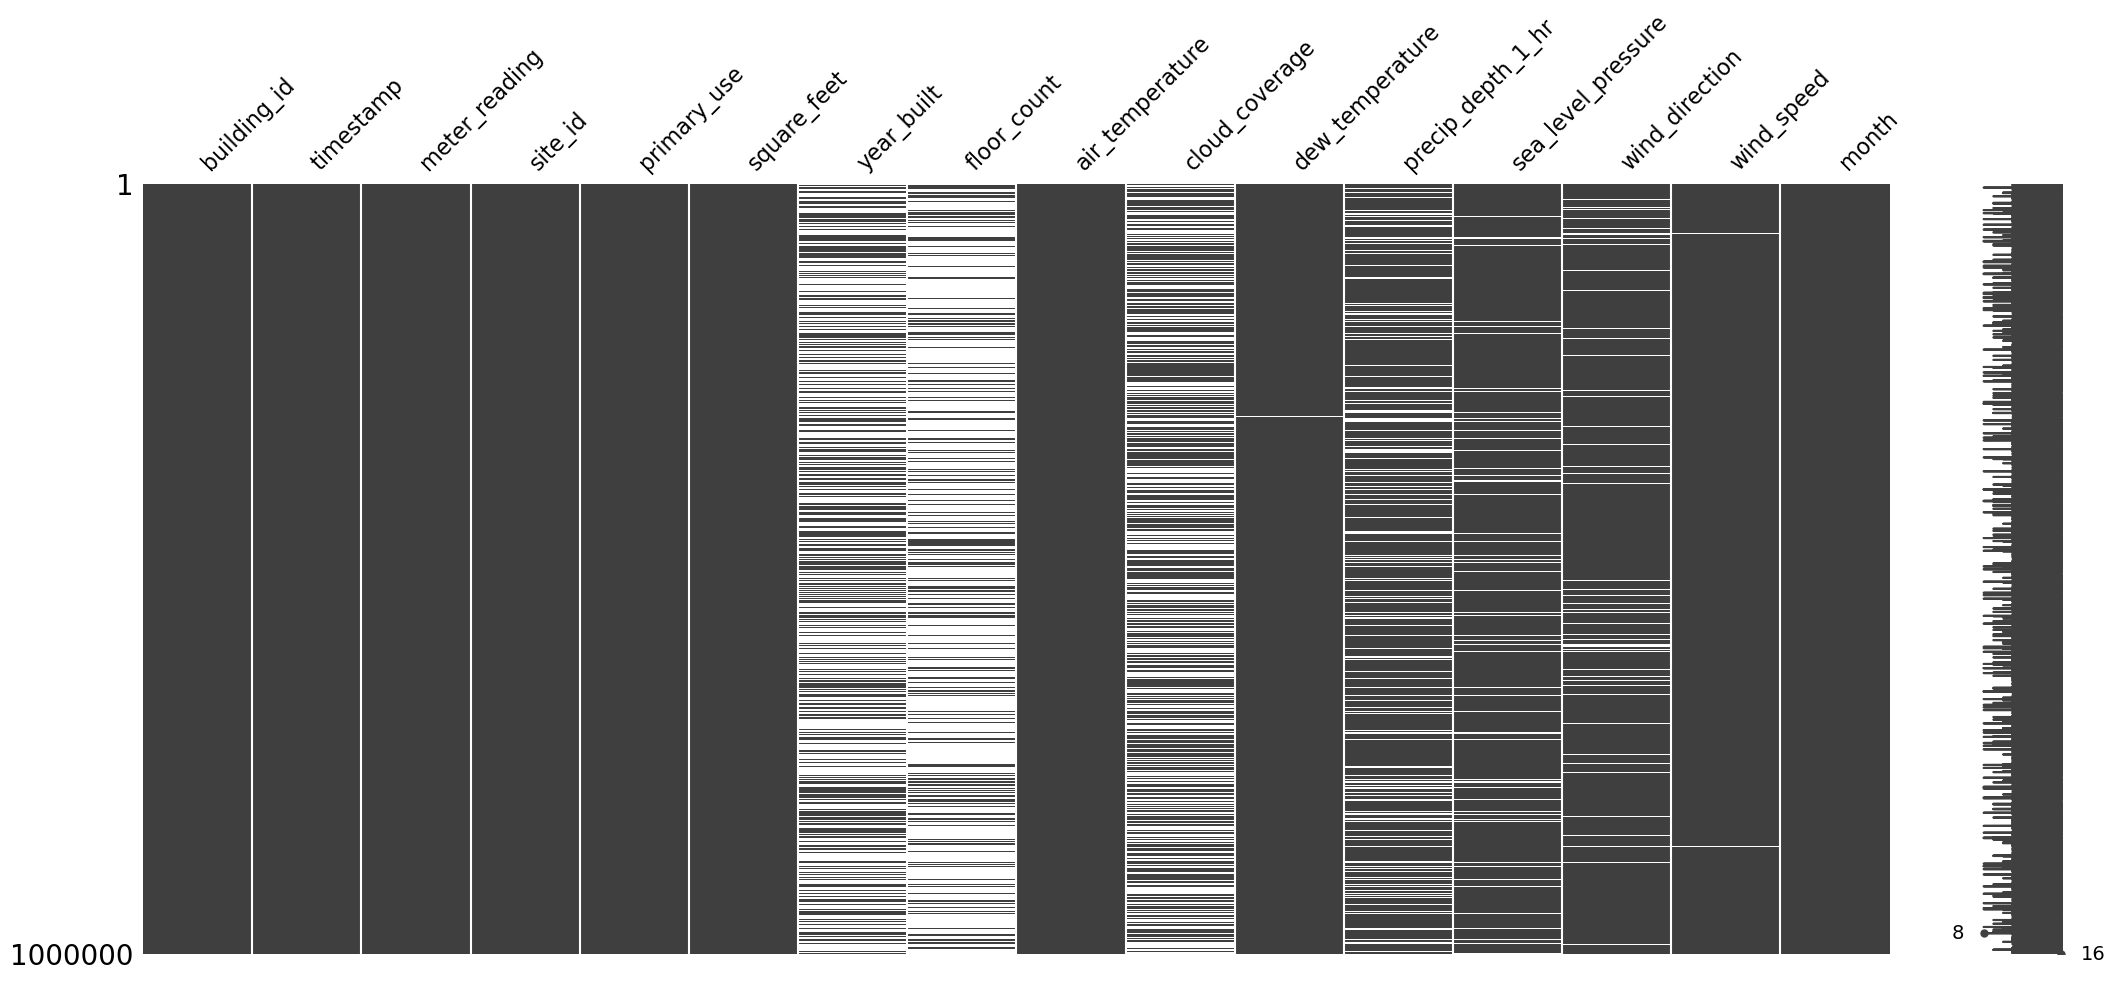

In [24]:
# Visualize missing values
msno.matrix(data.sample(1000000))

<Axes: >

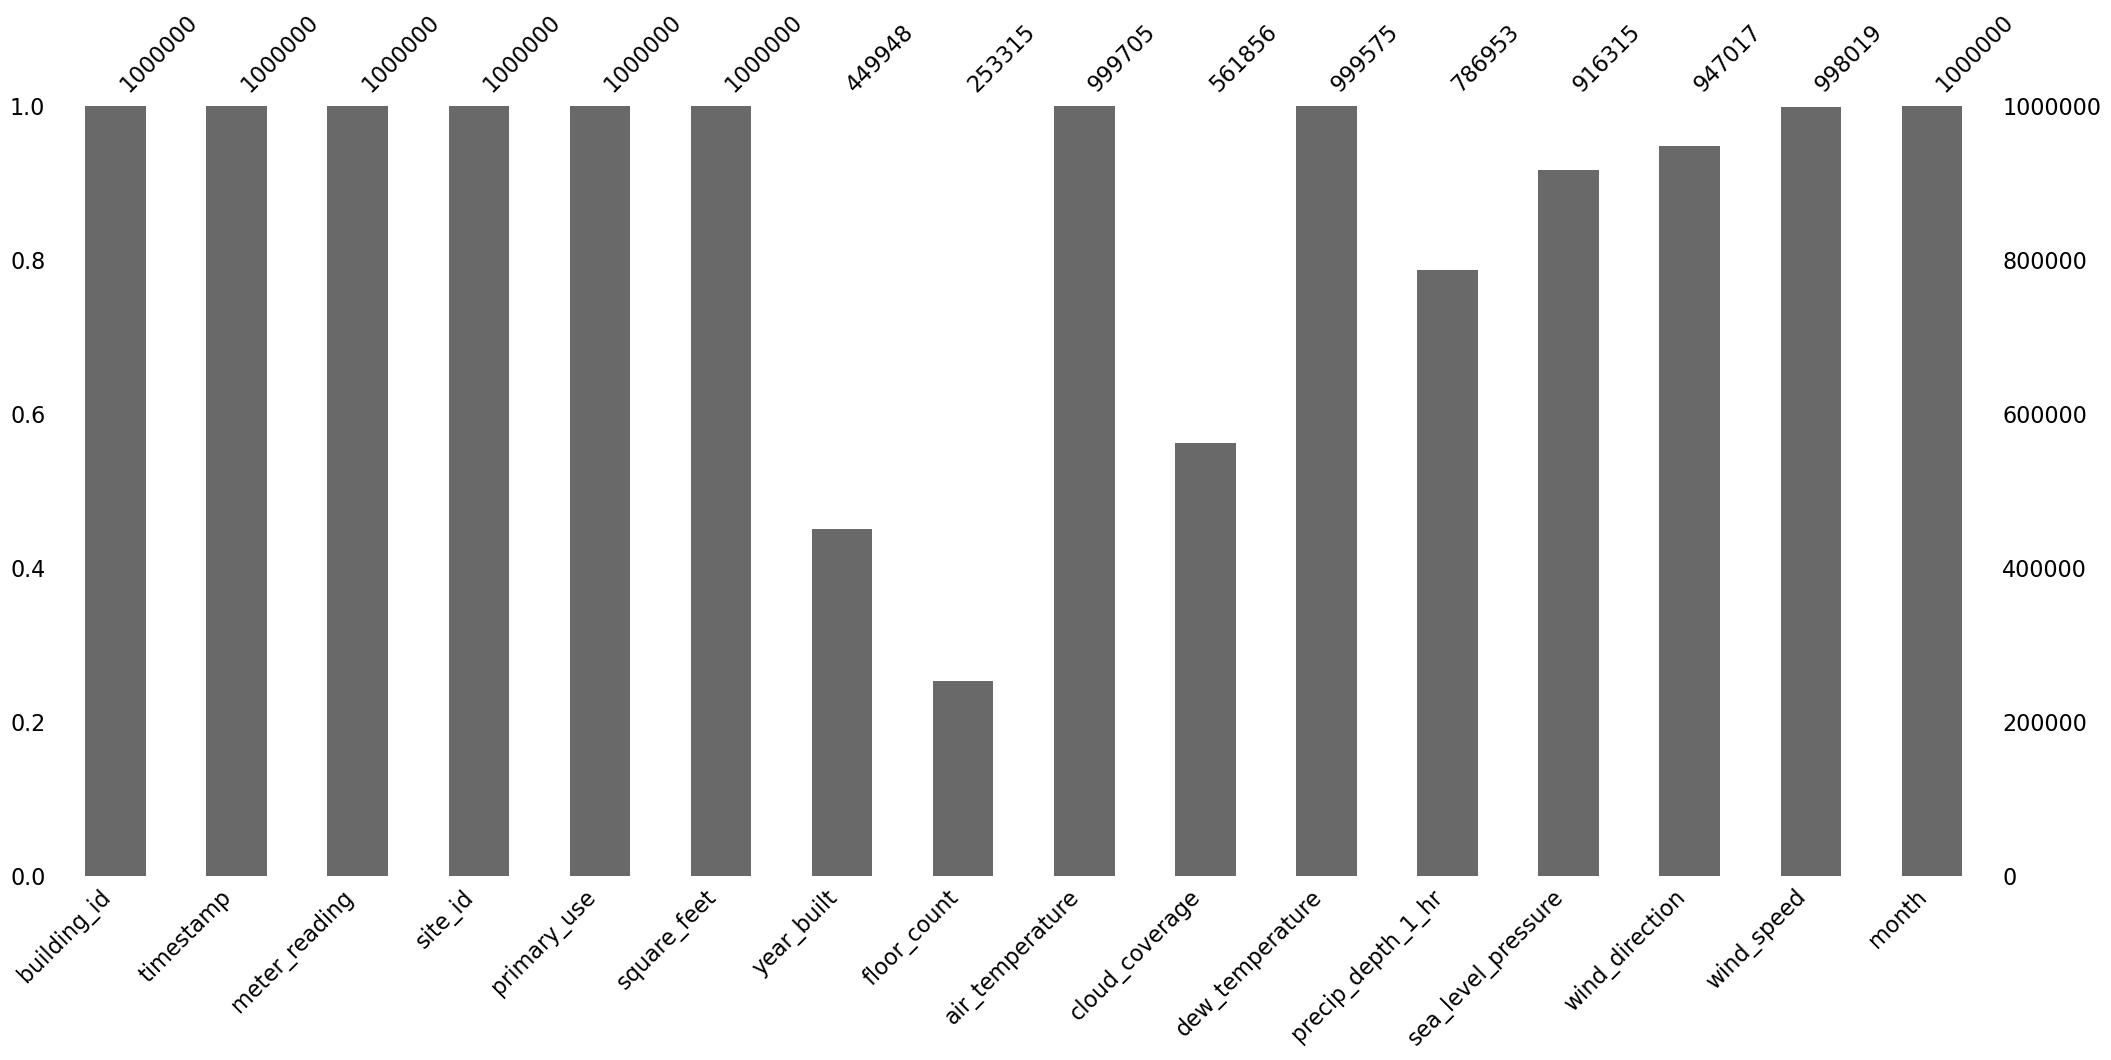

In [25]:
msno.bar(data.sample(1000000))

<Axes: >

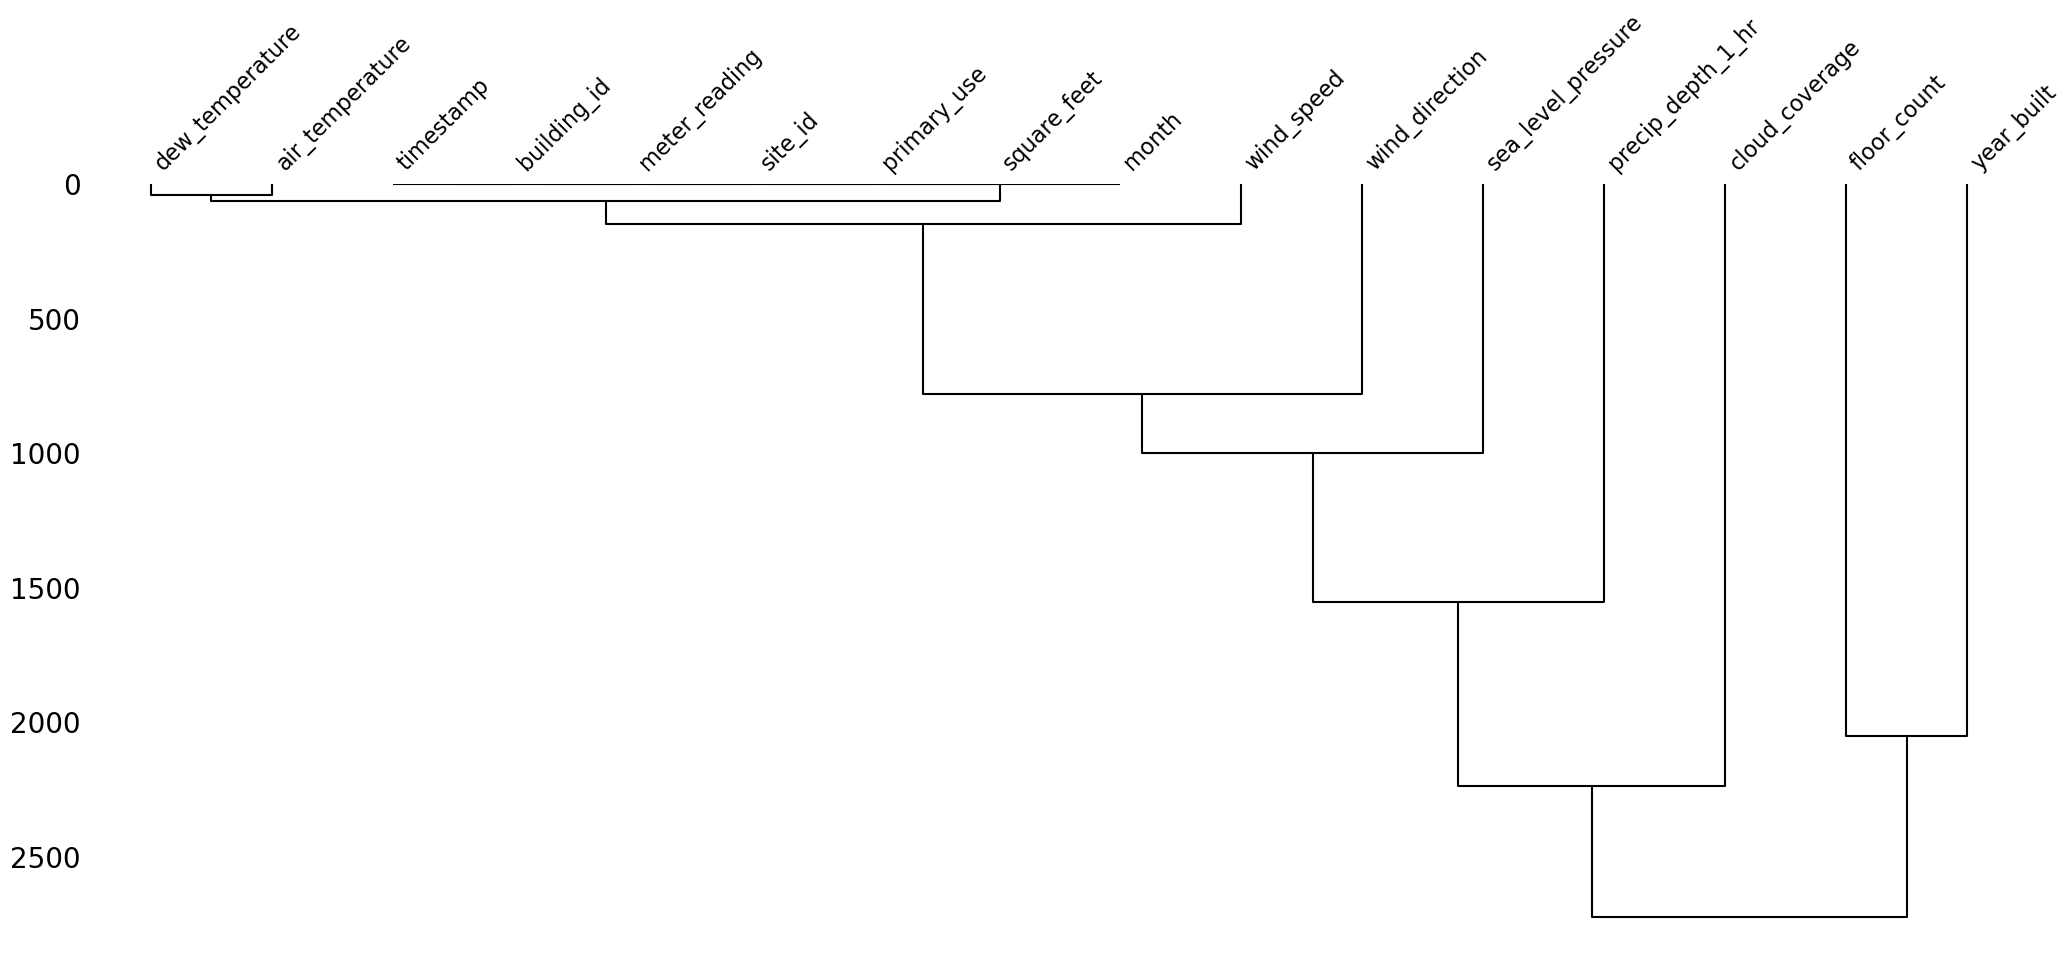

In [26]:
msno.dendrogram(data)

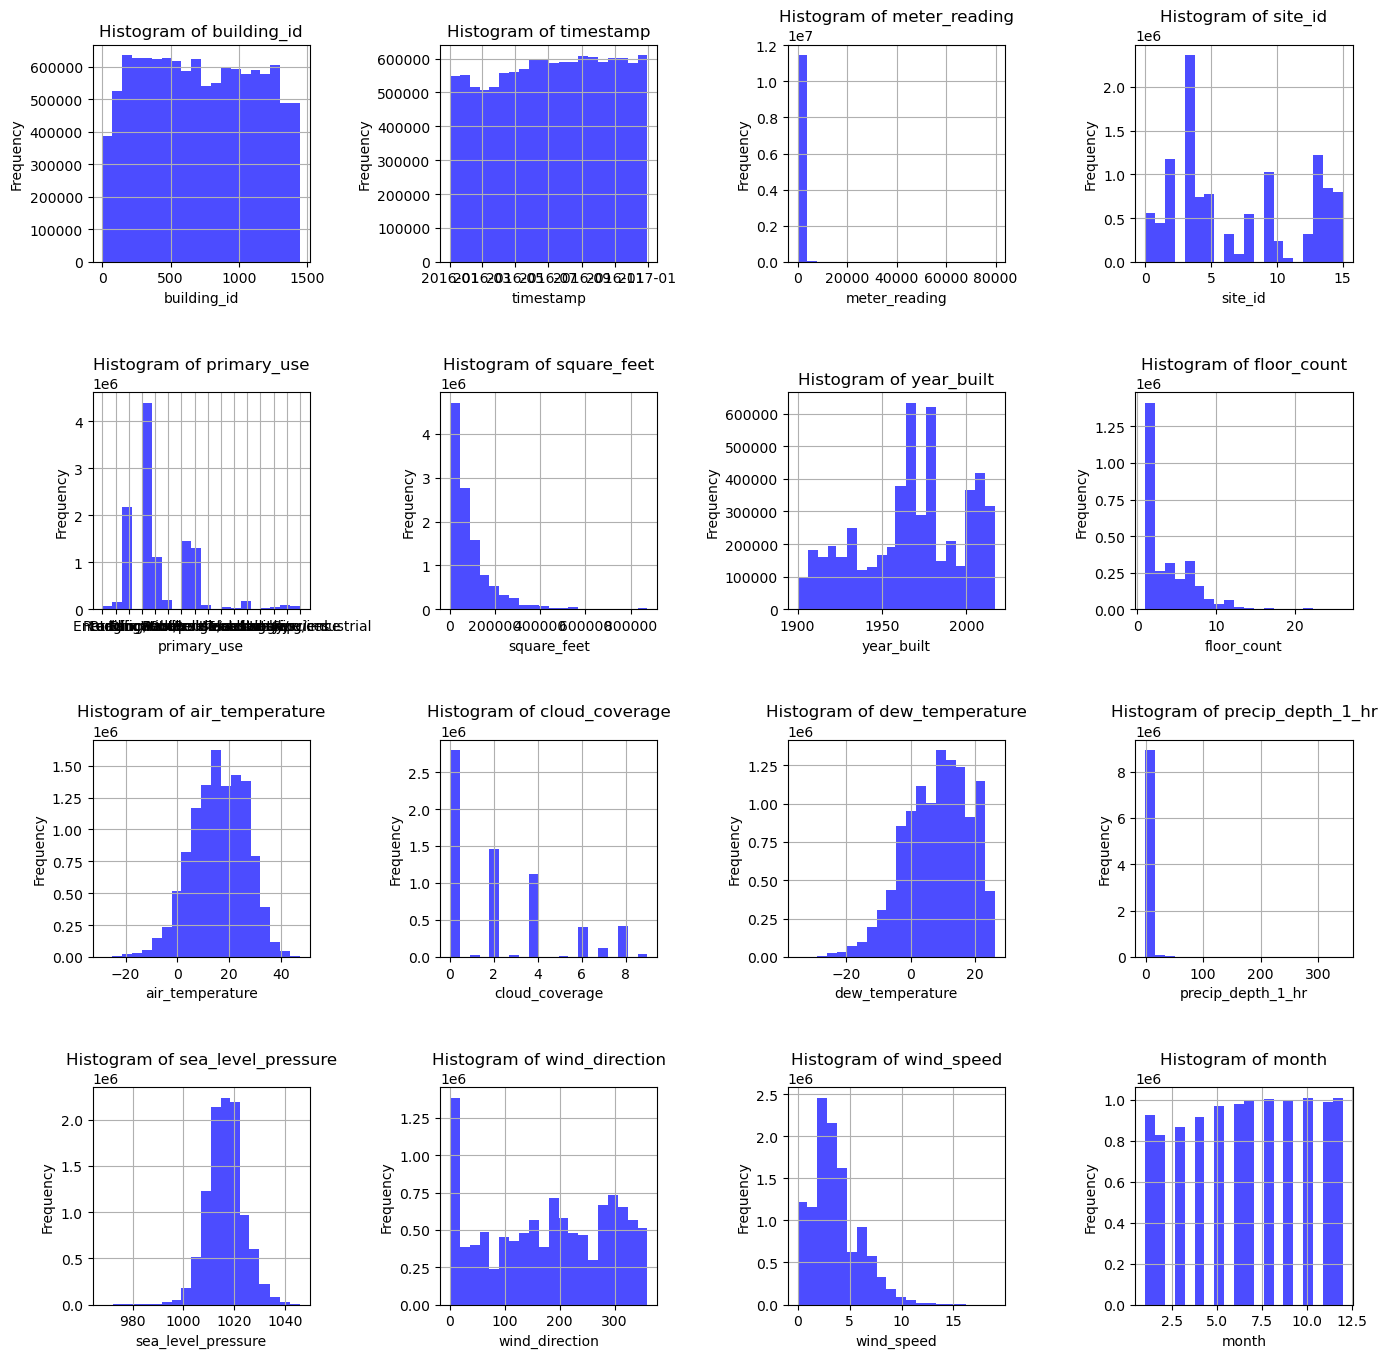

In [27]:
# Plot histograms for each column
def plot_data_dist(data):
  fig, axes = plt.subplots(4, 4, figsize=(18, 18))
  plt.subplots_adjust(left=0.1, right=0.8, top=0.8, bottom=0.1, wspace=0.6, hspace=0.6)
  for i, column in enumerate(data.columns):
      axes.flatten()[i].hist(data[column], bins=20, color='blue', alpha=0.7)
      axes.flatten()[i].set_title(f'Histogram of {column}')
      axes.flatten()[i].set_xlabel(column)
      axes.flatten()[i].set_ylabel('Frequency')
      axes.flatten()[i].grid(True)

  plt.show()


plot_data_dist(data)

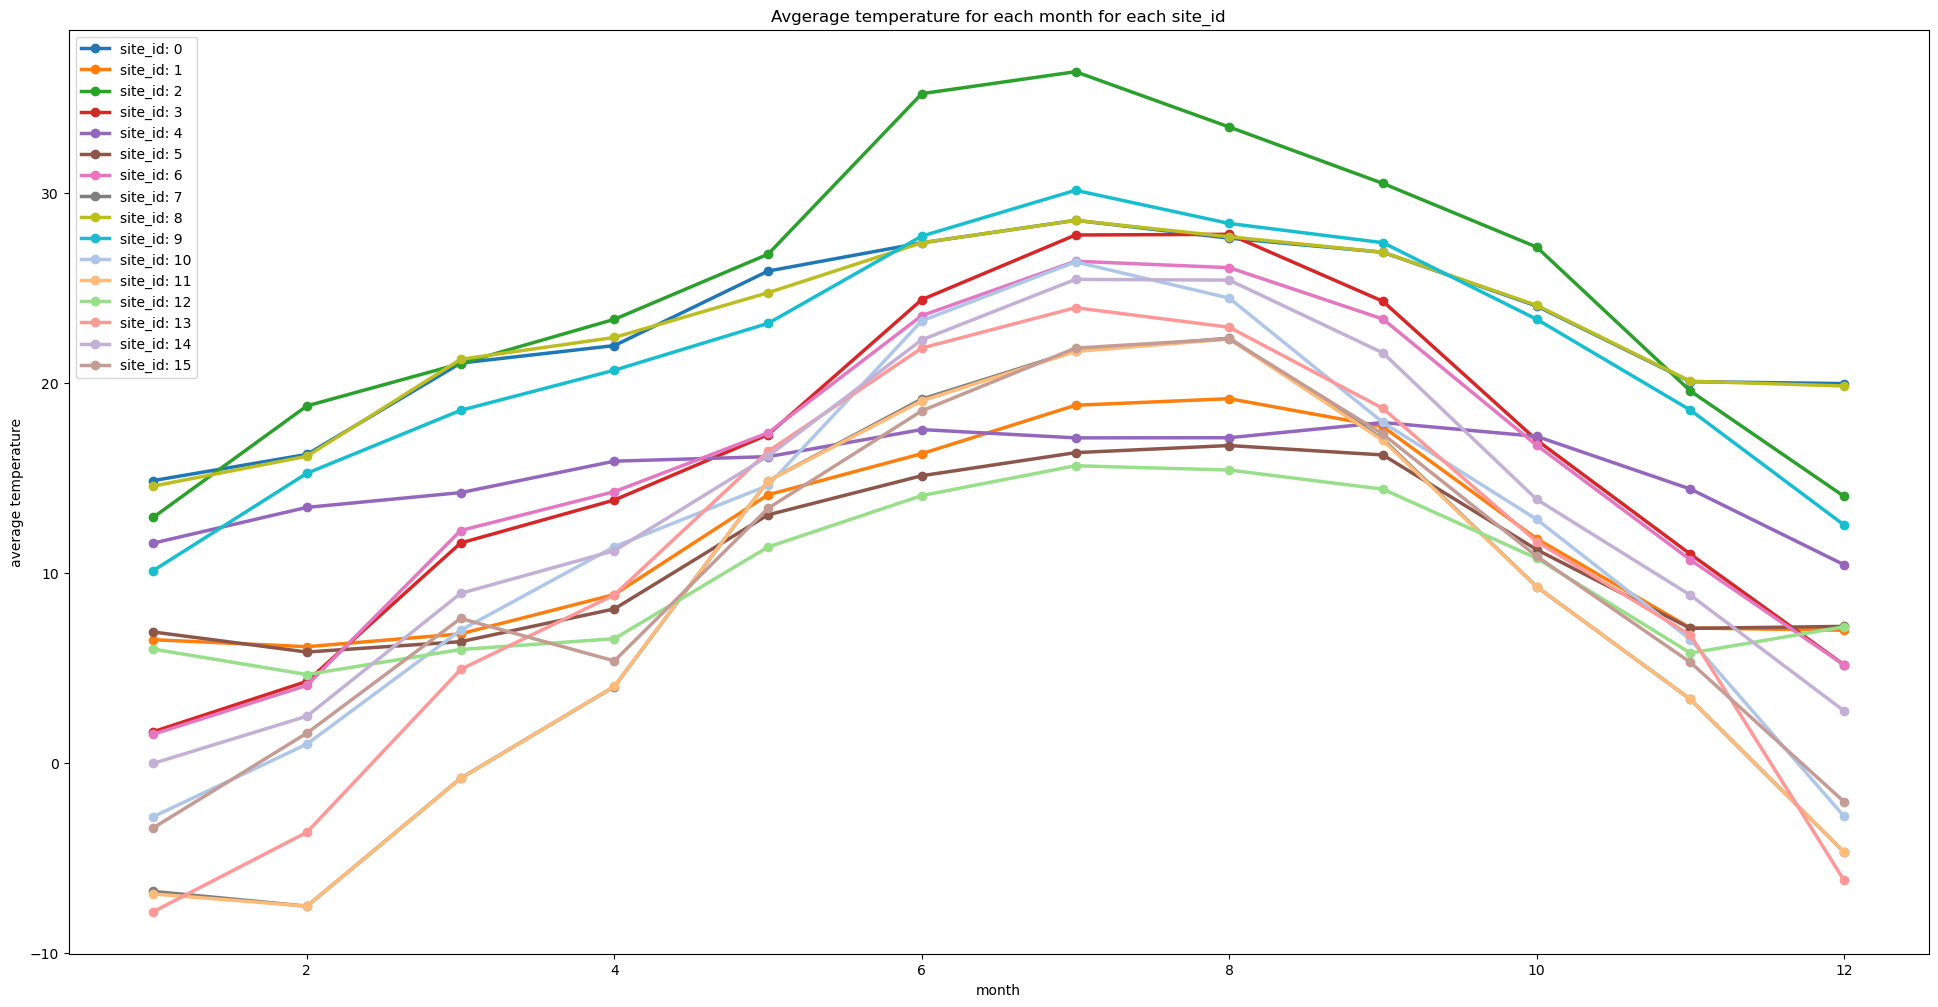

In [28]:
# Plot avregae temperatures in different months for each site_id
temp_grouped_avg = data.groupby(['site_id', 'month'])['air_temperature'].mean()
months = temp_grouped_avg.index.get_level_values(1).unique().values

siteid_colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Yellow-Green
    "#17becf",  # Cyan
    "#aec7e8",  # Light Blue
    "#ffbb78",  # Light Orange
    "#98df8a",  # Light Green
    "#ff9896",  # Light Red
    "#c5b0d5",  # Light Purple
    "#c49c94",  # Light Brown
]

plt.figure(figsize=(24, 12))
site_ids = temp_grouped_avg.index.get_level_values(0).unique().values

for site_id in site_ids:
    months = temp_grouped_avg[site_id].index.values
    temp_averages = temp_grouped_avg[site_id].values
    plt.plot(
        months,
        temp_averages,
        label = f'site_id: {site_id}',
        color=siteid_colors[site_id],
        lw=2.5,
        marker = 'o')

plt.xlabel('month')
plt.ylabel('average temperature')
plt.legend()
plt.title('Avgerage temperature for each month for each site_id')
plt.legend(loc='upper left')
plt.show()

In [29]:
del temp_grouped_avg

### Try a model without feature engineering

In [31]:
unpreprocessed_data = data.drop(['cloud_coverage', 'timestamp', 'year_built', 'floor_count'], axis=1)
mask = unpreprocessed_data.isnull().any(axis=1)
unpreprocessed_data = unpreprocessed_data.loc[~mask]


In [32]:
unpreprocessed_data.isnull().sum()

building_id           0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
month                 0
dtype: int64

In [33]:
unpreprocessed_data.primary_use.unique()

array(['Education', 'Retail', 'Lodging/residential', 'Parking', 'Office',
       'Other', 'Entertainment/public assembly', 'Public services',
       'Warehouse/storage', 'Food sales and service', 'Religious worship',
       'Healthcare', 'Utility', 'Technology/science', 'Services',
       'Manufacturing/industrial'], dtype=object)

In [34]:
primary_use_encoder = LabelEncoder()
unpreprocessed_data['primary_use'] = primary_use_encoder.fit_transform(unpreprocessed_data['primary_use'])

In [35]:
unpreprocessed_data.primary_use.unique()

array([ 0, 11,  4,  8,  6,  7,  1,  9, 15,  2, 10,  3, 14, 13, 12,  5])

In [36]:
features = unpreprocessed_data.drop('meter_reading', axis=1).values
target = unpreprocessed_data['meter_reading'].values

In [37]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.3, random_state=42)

In [38]:
dtr = DecisionTreeRegressor(max_depth=20, random_state=42)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, random_state=42)

In [39]:
r2_train_unpp = r2_score(y_train, dtr.predict(X_train))
r2_val_unpp = r2_score(y_val, dtr.predict(X_val))
print("R-squared for train data: {:.3f}".format(r2_train_unpp))
print("R-squared for validation data: {:.3f}".format(r2_val_unpp))

R-squared for train data: 0.978
R-squared for validation data: 0.901


In [40]:
del features, target
del X_train, X_val, y_train, y_val

### Feature Engineering

In [41]:
train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)
del data

In [42]:
def fillna_based_on_mean(feature):
  feature_type = train_data[feature].dtype
  feature_mean = train_data[feature].astype('float64').mean().astype(feature_type)
  train_data[feature].fillna(feature_mean, inplace=True)
  val_data[feature].fillna(feature_mean, inplace=True)

In [43]:
def fillna_based_on_group_means(feature):
  transformed_group_means = train_data.groupby(['site_id', 'month'])[feature].transform('mean').astype('float16')
  group_means = train_data.groupby(['site_id', 'month'])[feature].mean().astype('float16')
  train_data[feature].fillna(transformed_group_means, inplace=True)
  val_data[feature] = val_data.groupby(['site_id', 'month'])[feature].transform(lambda x: x.fillna(group_means.get(x.name)))


In [44]:
fillna_based_on_mean('sea_level_pressure')

In [45]:
fillna_based_on_mean('air_temperature')

In [46]:
train_data[['air_temperature', 'sea_level_pressure']].isnull().sum()

air_temperature       0
sea_level_pressure    0
dtype: int64

In [47]:
val_data[['air_temperature', 'sea_level_pressure']].isnull().sum()

air_temperature       0
sea_level_pressure    0
dtype: int64

In [49]:
def plot_means_medians(feature_name):
  means = train_data.groupby(['site_id', 'month'])[feature_name].mean()
  medians = train_data.groupby(['site_id', 'month'])[feature_name].median()
  site_ids = means.index.get_level_values(0).unique().values

  plt.figure(figsize=(24, 15))
  linestyles = ['--', ':']
  siteid_labels = [f'site_id: {site_id}' for site_id in site_ids]
  for site_id in site_ids:
      x = means[site_id].index.values
      y1 = means[site_id].values
      y2 = medians[site_id].values
      plt.plot(x, y1, linestyle= ':', color=siteid_colors[site_id], lw=2.5, marker='o')
      plt.plot(x, y2, linestyle='--', color=siteid_colors[site_id], lw=2.5, marker='o')

  plt.title(f'{feature_name} means and medians in different months, for each site_id')
  plt.xlabel('month')
  plt.ylabel('mean & median')
  legend1 = plt.legend([plt.Line2D([0], [0], linestyle=ls) for ls in linestyles], ["mean", "median"], loc=2)
  plt.legend([plt.Line2D([0], [0], color=siteid_colors[site_id]) for site_id in site_ids], siteid_labels, loc='upper right')
  plt.gca().add_artist(legend1)
  plt.show()


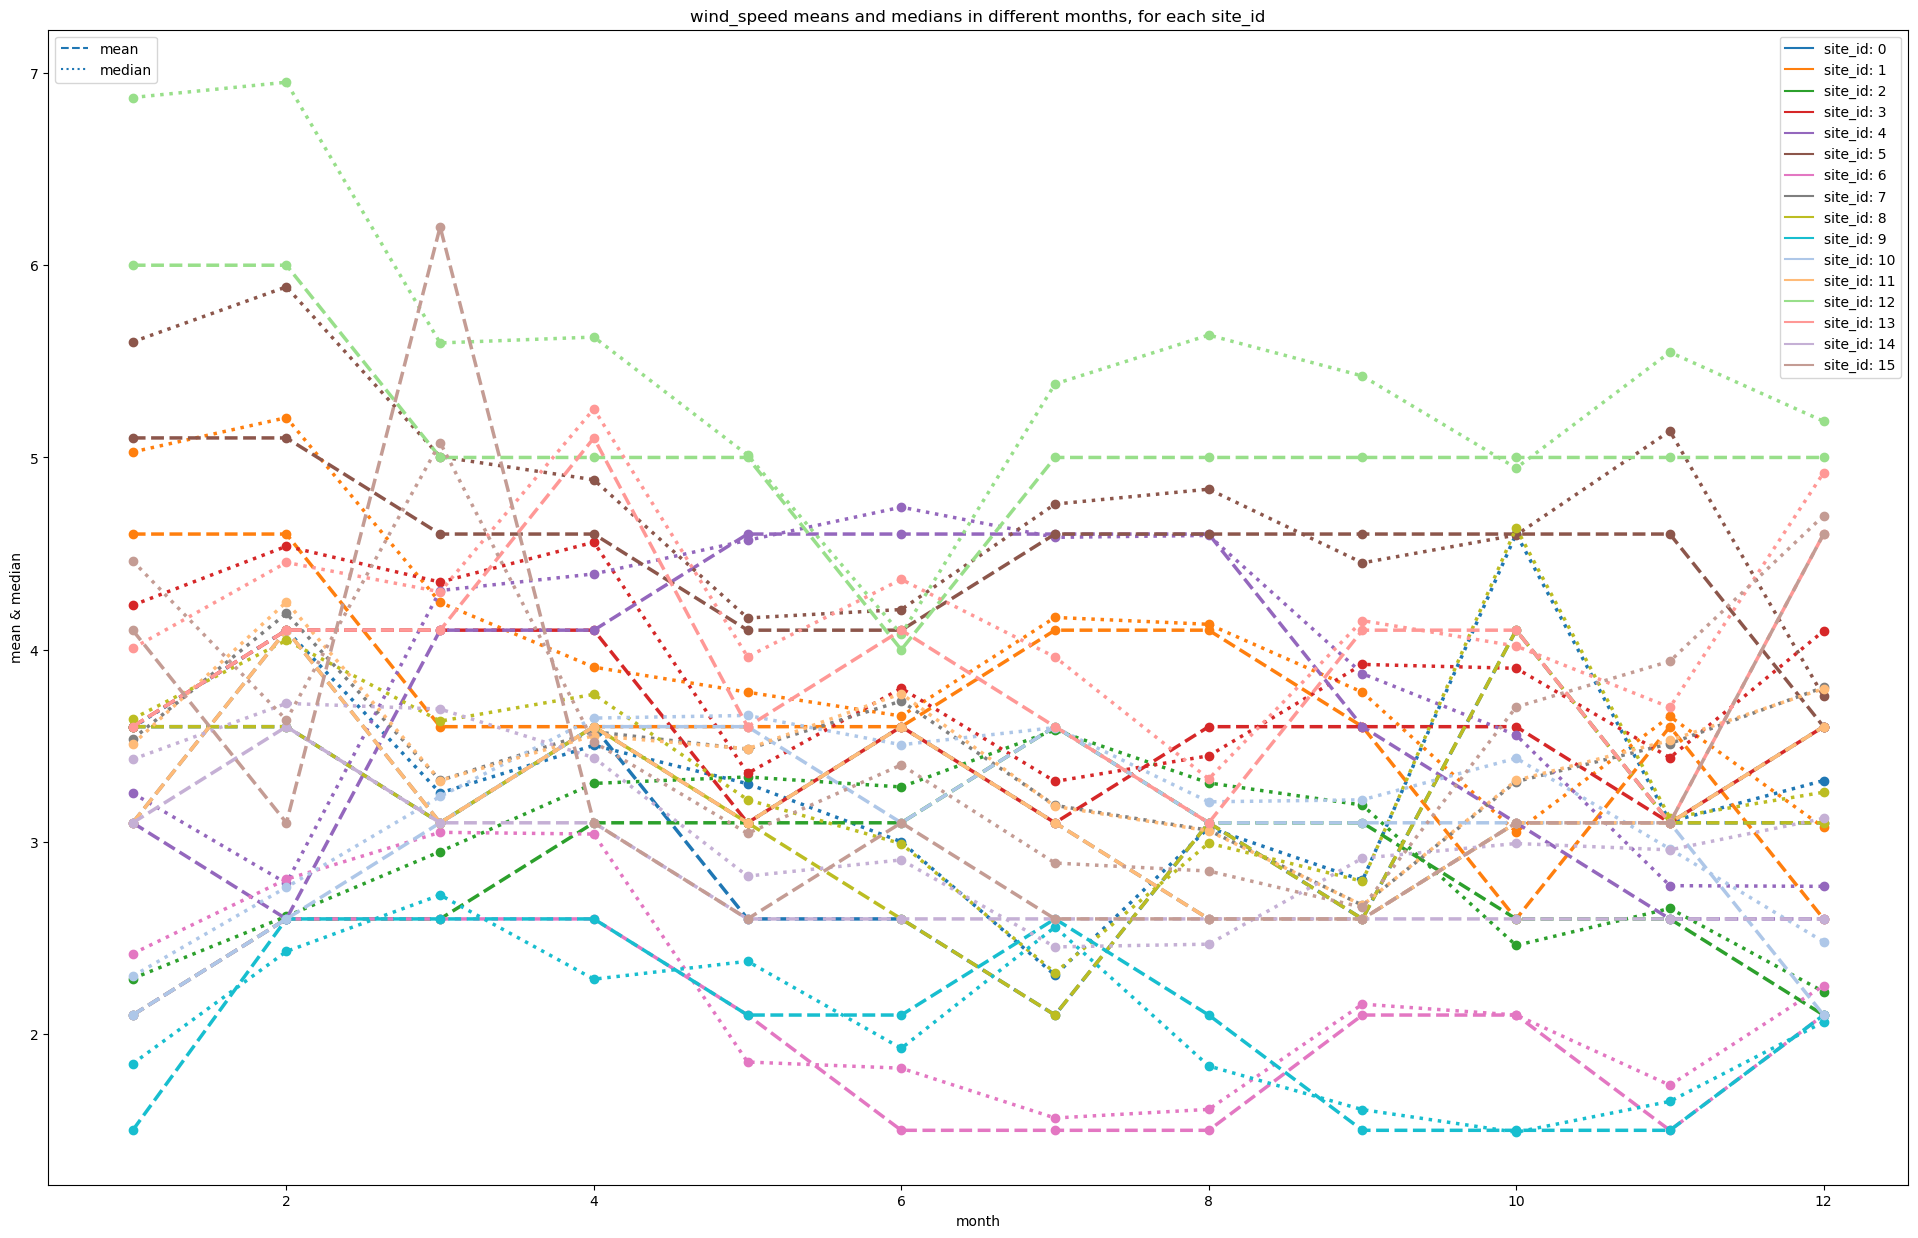

In [50]:
plot_means_medians('wind_speed')

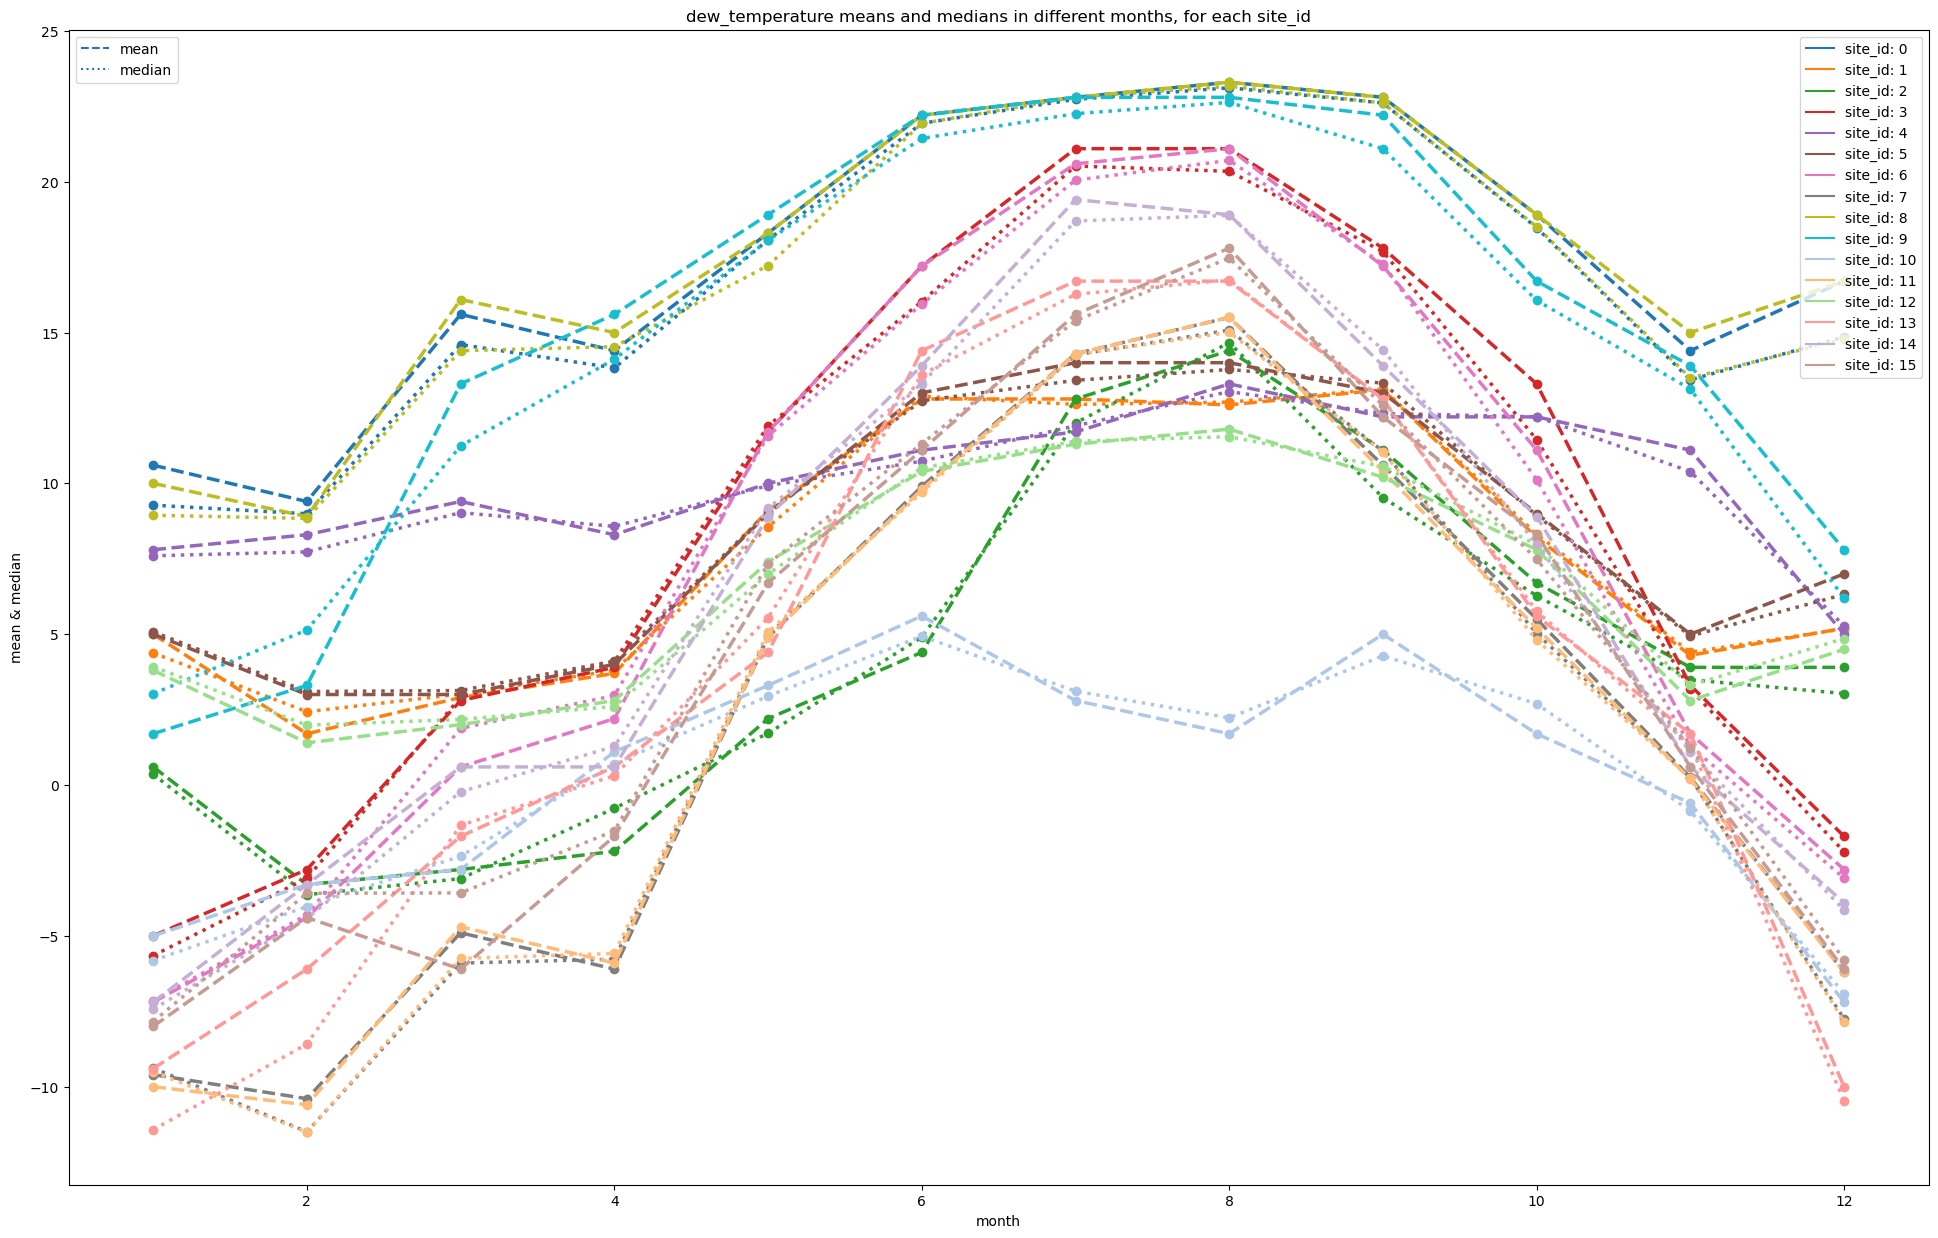

In [51]:
plot_means_medians('dew_temperature')

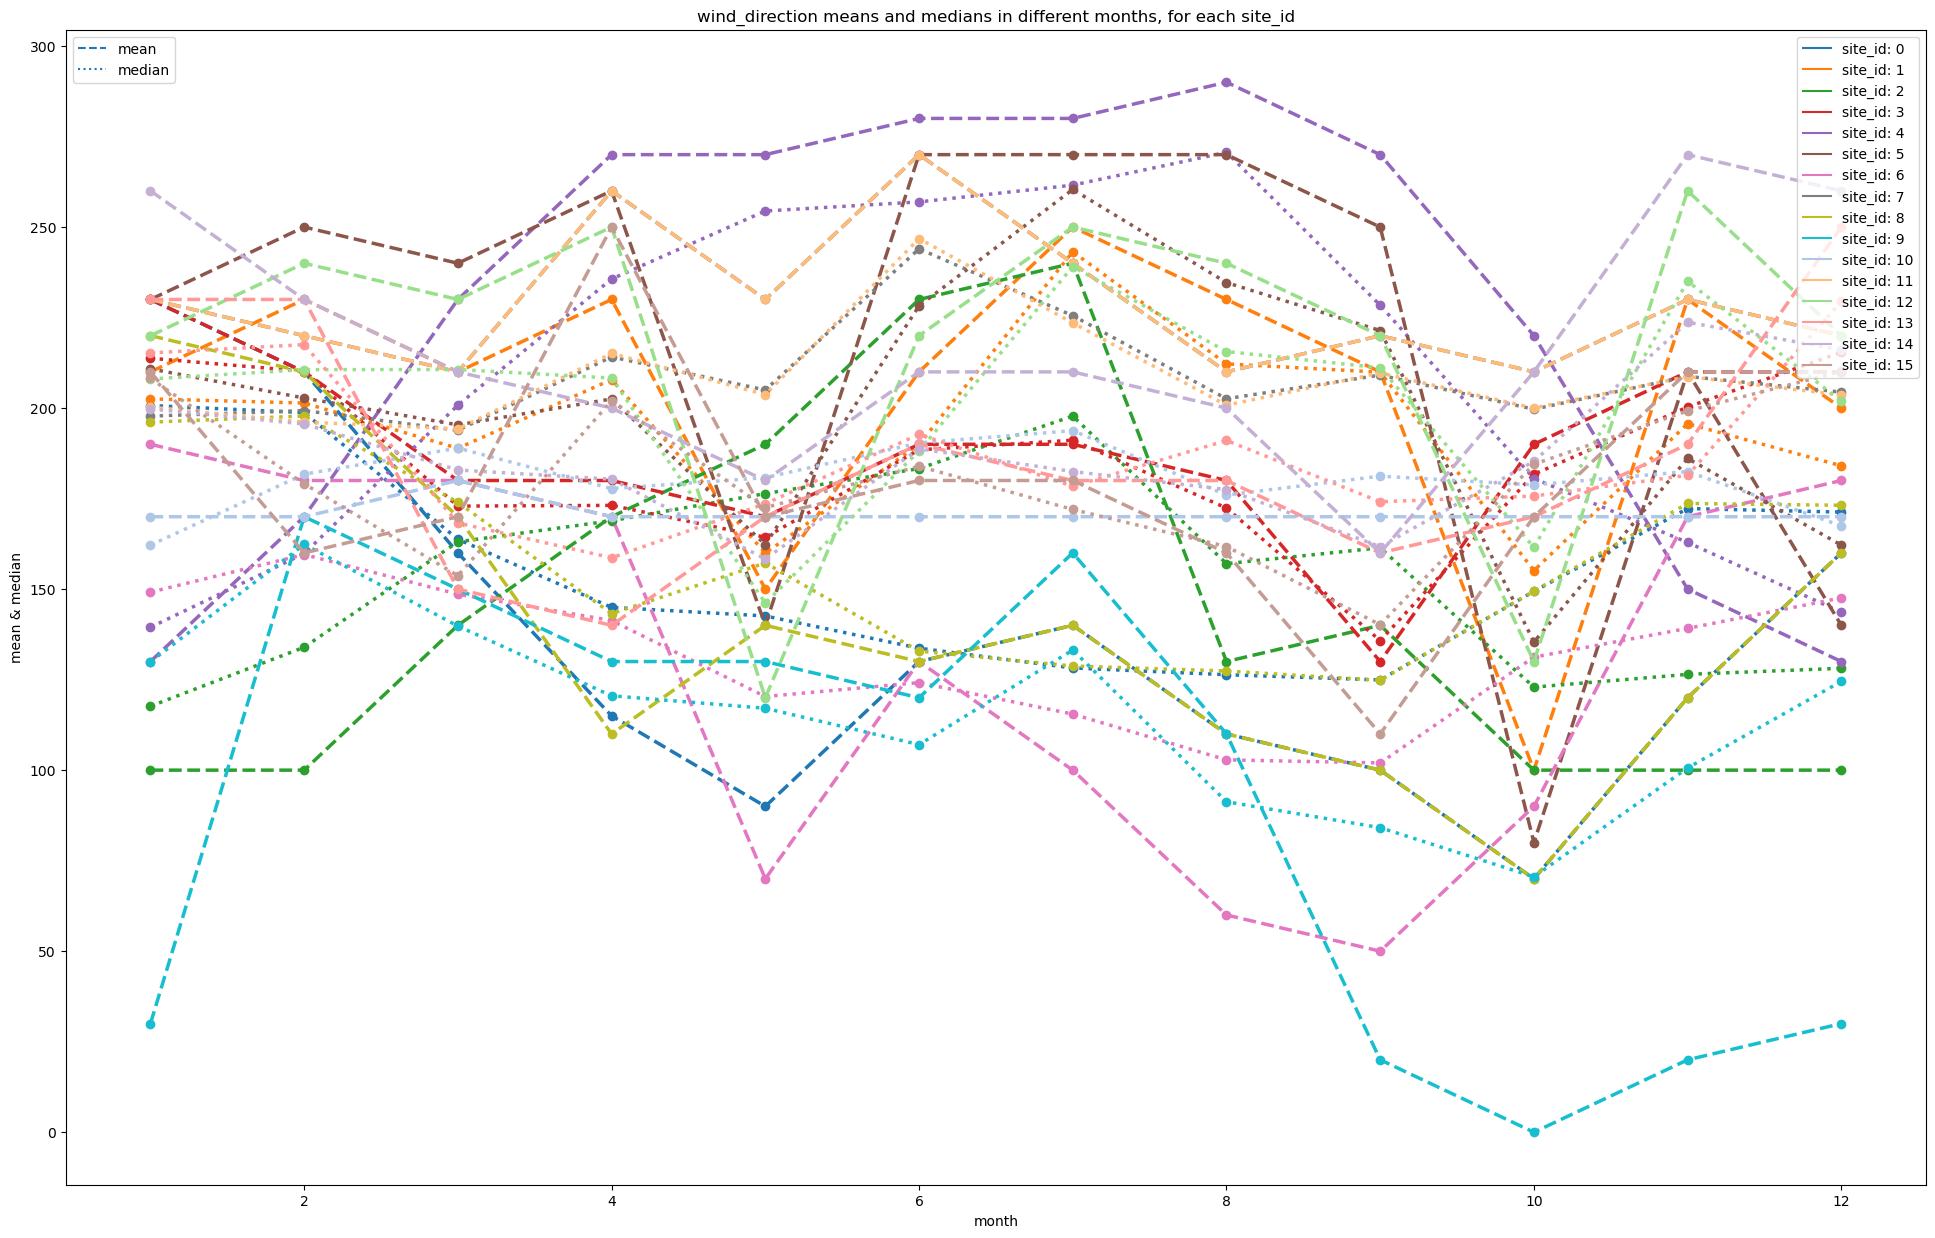

In [52]:
plot_means_medians('wind_direction')

In [53]:
fillna_based_on_mean('wind_speed')
fillna_based_on_mean('dew_temperature')

In [54]:
train_data[['wind_speed', 'dew_temperature']].isnull().sum()

wind_speed         0
dew_temperature    0
dtype: int64

In [55]:
val_data[['wind_speed', 'dew_temperature']].isnull().sum()

wind_speed         0
dew_temperature    0
dtype: int64

In [56]:
# Handling missing values in cloud_coverage using linear interpolatio
train_data.sort_values(by=['site_id', 'timestamp'], inplace=True)
val_data.sort_values(by=['site_id', 'timestamp'], inplace=True)
train_data['cloud_coverage'] = train_data['cloud_coverage'].interpolate(method='linear')
val_data['cloud_coverage'] = val_data['cloud_coverage'].interpolate(method='linear')

In [57]:
train_data['cloud_coverage'].isnull().sum()

0

In [58]:
val_data['cloud_coverage'].isnull().sum()

0

In [59]:
train_data['precip_depth_1_hr'].isnull().sum()/train_data.shape[0] * 100

21.235256592797818

In [60]:
zero_mask = (train_data['cloud_coverage'] == 0)
null_mask = (train_data['precip_depth_1_hr'].isnull())
train_data.loc[zero_mask & null_mask, 'precip_depth_1_hr'] = 0

In [61]:
train_data['precip_depth_1_hr'].isnull().sum() / train_data.shape[0] * 100

8.896319573027196

In [62]:
zero_mask = (val_data['cloud_coverage'] == 0)
null_mask = (val_data['precip_depth_1_hr'].isnull())
val_data.loc[zero_mask & null_mask, 'precip_depth_1_hr'] = 0

In [63]:
fillna_based_on_group_means('precip_depth_1_hr')
train_data[train_data['precip_depth_1_hr'].isnull()] = -1
val_data[val_data['precip_depth_1_hr'].isnull()] = -1

In [64]:
train_data['precip_depth_1_hr'].isnull().sum()

0

In [65]:
val_data['precip_depth_1_hr'].isnull().sum()

0

In [66]:
del zero_mask, null_mask

In [67]:
train_data_backup = train_data.copy()
val_data_backup = val_data.copy()

train_data.drop('year_built', axis=1, inplace=True)
val_data.drop('year_built', axis=1, inplace=True)

train_data = train_data.loc[~train_data['floor_count'].isnull()]
val_data = val_data.loc[~val_data['floor_count'].isnull()]

In [68]:
train_data.isnull().sum()

building_id               0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
floor_count               0
air_temperature           0
cloud_coverage            0
dew_temperature           0
precip_depth_1_hr         0
sea_level_pressure        0
wind_direction        45199
wind_speed                0
month                     0
dtype: int64

In [69]:
val_data.isnull().sum()

building_id               0
timestamp                 0
meter_reading             0
site_id                   0
primary_use               0
square_feet               0
floor_count               0
air_temperature           0
cloud_coverage            0
dew_temperature           0
precip_depth_1_hr         0
sea_level_pressure        0
wind_direction        19485
wind_speed                0
month                     0
dtype: int64

In [70]:
# Analysing primary_use column
aggregated = train_data.groupby('primary_use')['meter_reading'].agg(['mean', 'count'])
aggregated['percentages'] = aggregated['count'] / train_data.shape[0] * 100
aggregated.sort_values(by='mean', inplace=True)
aggregated

,mean,count,percentages
primary_use,,,
-1,-1.000000,92113,4.373442
Warehouse/storage,16.434780,11299,0.536466
Healthcare,20.244806,6113,0.290240
Other,20.489431,74284,3.526937
Parking,32.521072,14509,0.688874
Retail,37.460041,7156,0.339760
Utility,52.712971,6119,0.290525
Public services,54.786903,235536,11.183037
Lodging/residential,63.420830,107131,5.086483


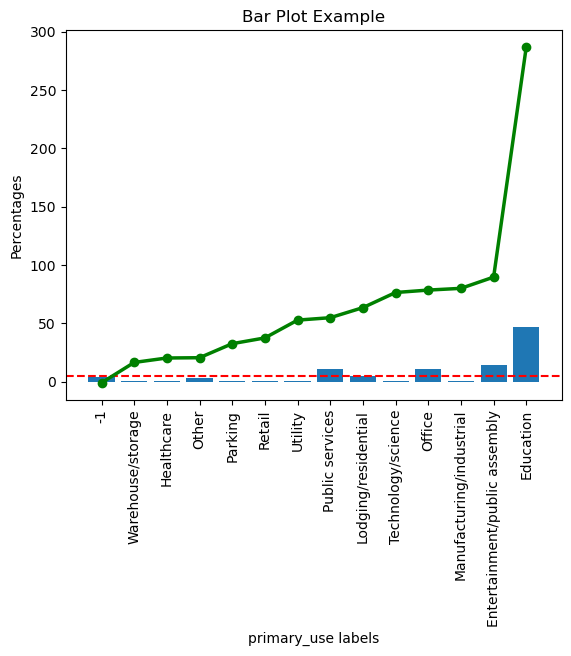

In [71]:
categories = aggregated.index.values.astype('str')
plt.bar(categories, aggregated['percentages'])
plt.axhline(y=5, color='r', linestyle='--')
plt.plot(
    categories, aggregated['mean'],
    label='Average power consumption',
    color='g',
    lw=2.5,
    marker = 'o')
plt.xlabel('primary_use labels')
plt.ylabel('Percentages')
plt.title('Bar Plot Example')
plt.xticks(rotation=90)
plt.show()

In [72]:
# Bin primary_use column
mask = train_data['primary_use'].isin(['Parking', 'Utility', 'Retail'])
train_data.loc[mask, 'primary_use'] = 'others'

In [73]:
mask = val_data['primary_use'].isin(['Parking', 'Utility', 'Retail'])
val_data.loc[mask, 'primary_use'] = 'others'

In [74]:
del mask, aggregated

In [75]:
train_data['primary_use'] = train_data['primary_use'].astype('str')
val_data['primary_use'] = val_data['primary_use'].astype('str')

In [76]:
primary_use_encoder = LabelEncoder()
train_data['primary_use'] = primary_use_encoder.fit_transform(train_data['primary_use'])
val_data['primary_use'] = primary_use_encoder.transform(val_data['primary_use'])

In [77]:
# Remove month and timestamp columns and split target column)
train_data.drop(['month', 'timestamp'], axis=1, inplace=True)
val_data.drop(['month', 'timestamp'], axis=1, inplace=True)

train_data = train_data.sample(frac=1, random_state=42)
val_data = val_data.sample(frac=1, random_state=42)

target_train = train_data[['meter_reading']]
features_train = train_data.drop('meter_reading', axis=1)
target_val = val_data[['meter_reading']]
features_val = val_data.drop('meter_reading', axis=1)

In [78]:
del train_data, val_data

In [80]:
# KNNImputer
knn_imputer = KNNImputer(
    n_neighbors=5,
    weights='distance',
    metric='nan_euclidean',
    add_indicator=False)

features_train = pd.DataFrame(
    knn_imputer.fit_transform(features_train),
    columns=features_train.columns)

features_val = pd.DataFrame(
    knn_imputer.transform(features_val),
    columns=features_val.columns)

In [81]:
features_train.isnull().sum()

building_id           0
site_id               0
primary_use           0
square_feet           0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [82]:
features_val.isnull().sum()

building_id           0
site_id               0
primary_use           0
square_feet           0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [83]:
# StandardScaler
ss_scaler = StandardScaler()
features_train = pd.DataFrame(
    ss_scaler.fit_transform(features_train),
    columns=features_train.columns)

features_val = pd.DataFrame(
    ss_scaler.transform(features_val),
    columns=features_val.columns)

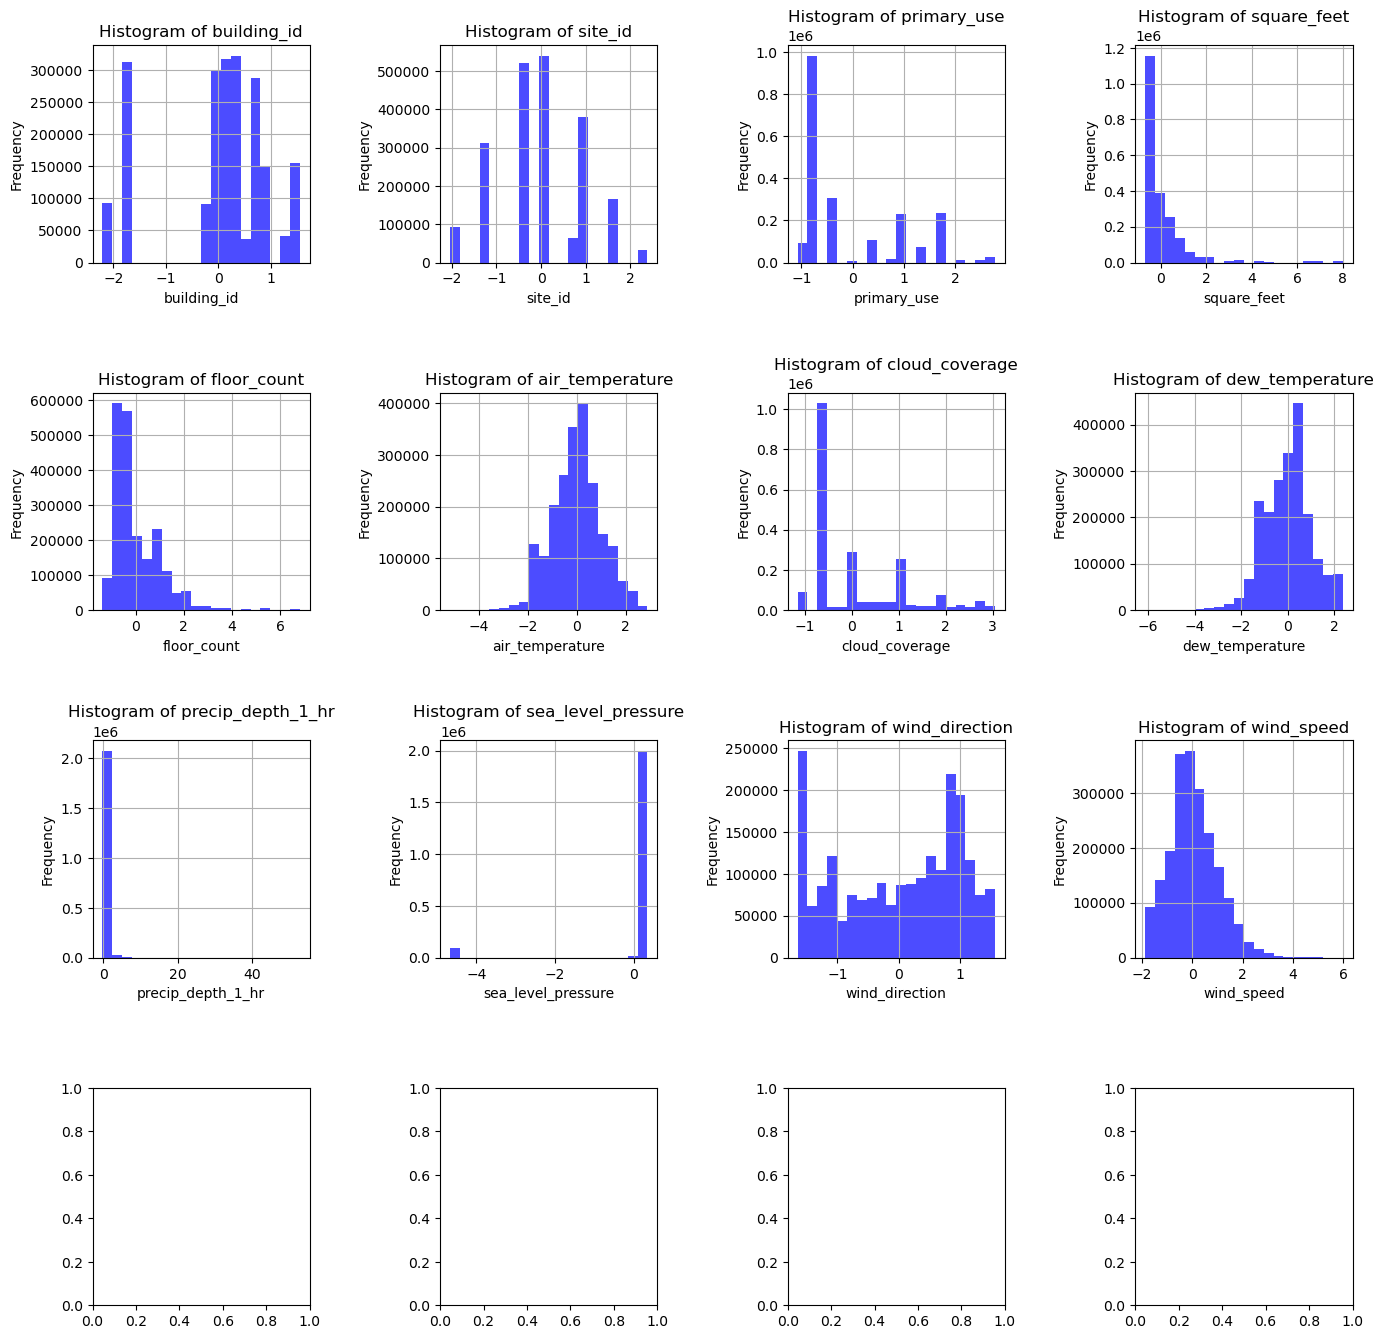

In [84]:
plot_data_dist(features_train)

In [117]:
# Now, try a model after feature engineering
X_train = features_train.values
y_train = target_train.values

dtr = DecisionTreeRegressor(max_depth=20, random_state=42)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, random_state=42)

In [118]:
X_val = features_val.values
y_val = target_val.values

r2_train_pp = r2_score(y_train, dtr.predict(X_train))
r2_val_pp = r2_score(y_val, dtr.predict(X_val))
print("R-squared for preprocessed train data: {:.3f}".format(r2_train_pp))
print("R-squared for preprocessed validation data: {:.3f}".format(r2_val_pp))

R-squared for preprocessed train data: 0.986
R-squared for preprocessed validation data: 0.924


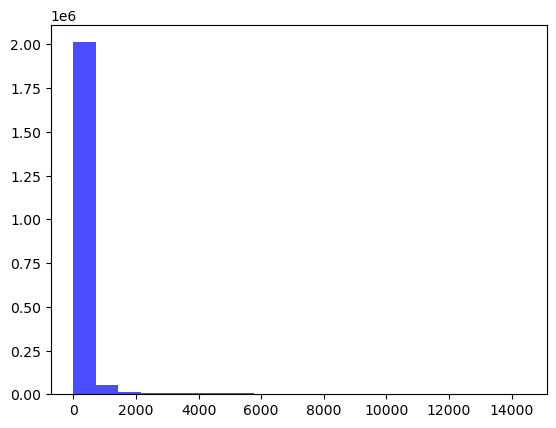

In [119]:
 plt.hist(target_train, bins=20, color='blue', alpha=0.7)
 plt.show()

In [120]:
# Try PowerTransformer and see if it improves the model
pt = PowerTransformer()
y_train = pt.fit_transform(target_train)
y_val = pt.transform(target_val)

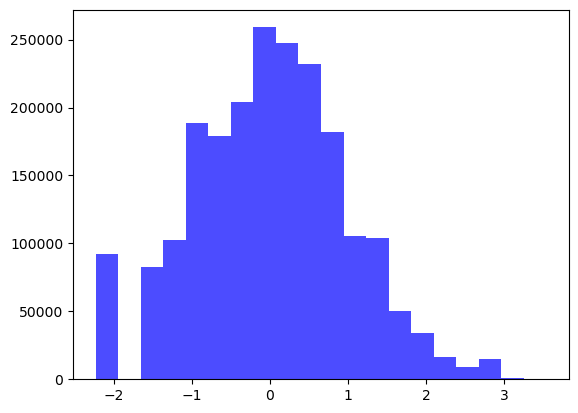

In [122]:
 plt.hist(y_train, bins=20, color='blue', alpha=0.7)
 plt.show()

In [123]:
dtr = DecisionTreeRegressor(max_depth=20, random_state=42)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, random_state=42)

In [124]:
r2_train_pp = r2_score(y_train, dtr.predict(X_train))
r2_val_pp = r2_score(y_val, dtr.predict(X_val))
print("R-squared for preprocessed train data (with powerTrasnformed target): {:.3f}".format(r2_train_pp))
print("R-squared for preprocessed validation data (with powerTrasnformed target): {:.3f}".format(r2_val_pp))

R-squared for preprocessed train data (with powerTrasnformed target): 0.962
R-squared for preprocessed validation data (with powerTrasnformed target): 0.941


In [ ]:
# To-Do (Predicting floor_count based on other features)